# Feature extraction from audio and data files and classification of PD

Code for finding directory structure, do feature extraction and classification.

Import libraries

In [1]:
# Libraries
import os
import re
import sys
import glob
import time
import pickle
import librosa
import numpy as np
import pandas
import tensorflow as keras
import matplotlib.pyplot as plt
import shutil


# Disvoice
from disvoice.articulation import Articulation

# SVM
from sklearn.svm import SVC 
from sklearn import datasets
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# CNN
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow import keras

# Confusion matrix, recall, precision, roc
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

2024-01-08 23:16:06.178976: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 23:16:06.179000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 23:16:06.179018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 23:16:06.183925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 23:16:06.709395: W tensorflow/compiler/

In [2]:
sys.path.append("../")
os.environ['KALDI_ROOT']='/localhome/studenter/duyenkl/kaldi'

# Define location of source data and the target root directory

The code copies the directory structure of the source root. In this case, the 16kHz version of PC-GITA to a new root location.

In [3]:
# Specify source root directory (for 16kHz version of PC-GITA)
gita_dir = '/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/'

# Specify subdirectory within the source root (with 16kHz version of PC-GITA)
source_dir = os.path.join(gita_dir, 'PC-GITA_per_task_16000Hz')

# Specify new root location
trgt_root = '/localhome/studenter/duyenkl/Parkinson'

# Create paths for csv file, model directory and metadata in target root directory
thecsv = os.path.join(trgt_root, 'wav.csv')
model_root = os.path.join(trgt_root, 'Models')
os.makedirs(model_root, exist_ok=True)

verbose_feat = False

In [4]:
# Check existence of directories
print('gita_dir:' + gita_dir)
print('source_dir: ' + source_dir)
print('trgt_root:' + trgt_root)
print('\n')

# Check content of source_dir
print('Content of source_dir: ')
print(os.listdir(source_dir))

gita_dir:/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/
source_dir: /localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PC-GITA_per_task_16000Hz
trgt_root:/localhome/studenter/duyenkl/Parkinson


Content of source_dir: 
['.DS_Store', 'DDK_analysis', 'modulated_vowels', 'monologue', 'read_text', 'sentences', 'sentences2', 'Vowels', 'Words']


# Create target directory structure

The code finds all wav files in the source directory structure, such that feature files can be written to a location in the target directory structure that corresponds to the location in the source root directory. The code to create directory structure in a target root directory structure is generated and adapted from ChatGPT, and processed by the author (2024).

Source: https://chat.openai.com/c/859058cd-c86d-4809-b5b1-5939fbd0c66d

In [5]:
# For each found directory, create a corresponding directory structure in a target root directory
for dirs in [x[0] for x in os.walk(source_dir)]:
    dir_path = os.path.relpath(dirs, source_dir)
    trgt_dir = os.path.join(trgt_root, dir_path)
    print(trgt_dir)
    try:
        os.makedirs(trgt_dir,exist_ok=True)
    except Exception as e:
        print('Error creating directory' + trgt_dir + e)

/localhome/studenter/duyenkl/Parkinson/.
/localhome/studenter/duyenkl/Parkinson/DDK_analysis
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/ka-ka-ka
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/ka-ka-ka/sin_normalizar
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/ka-ka-ka/sin_normalizar/hc
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/ka-ka-ka/sin_normalizar/pd
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/pa-pa-pa
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/pa-pa-pa/sin_normalizar
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/pa-pa-pa/sin_normalizar/hc
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/pa-pa-pa/sin_normalizar/pd
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/pakata
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/pakata/sin_normalizar
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/pakata/sin_normalizar/hc
/localhome/studenter/duyenkl/Parkinson/DDK_analysis/pakata/sin_normalizar/pd
/localhome/studenter/duyenkl/P

# Look into the meta data about the patients

About the columns
* RECODING ORIGINAL NAME: file name of recording
* UPDRS: Parkinson’s disease rating scale
* UPDRS-speech Parkinson’s disease rating scale related to speech
* H/Y: Hoehn&Yahr scale, Parkinson's disease rating scale


In [6]:
metadata_path = '/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PCGITA_metadata.xlsx'
metadata = pandas.read_excel(metadata_path)

idfull = list(metadata['RECODING ORIGINAL NAME'])
for id in range(len(idfull)):
    idfull[id]=idfull[id].replace('AVPEPUDE', '')
metadata.insert(0, 'ID', idfull, True)
metadata.head(100)


,ID,RECODING ORIGINAL NAME,UPDRS,UPDRS-speech,H/Y,SEX,AGE,time after diagnosis
0,A0001,AVPEPUDEA0001,28.0,1.0,2.0,M,64,3.0
1,A0002,AVPEPUDEA0002,19.0,0.0,1.0,F,72,2.5
2,A0003,AVPEPUDEA0003,52.0,2.0,3.0,F,75,3.0
3,A0005,AVPEPUDEA0005,32.0,1.0,2.0,M,65,12.0
4,A0006,AVPEPUDEA0006,28.0,1.0,2.0,F,66,4.0
...,...,...,...,...,...,...,...,...
95,AC0051,AVPEPUDEAC0051,NaN,NaN,NaN,M,31,NaN
96,AC0052,AVPEPUDEAC0052,NaN,NaN,NaN,M,42,NaN
97,AC0053,AVPEPUDEAC0053,NaN,NaN,NaN,F,50,NaN
98,AC0054,AVPEPUDEAC0054,NaN,NaN,NaN,F,49,NaN


# Get some statistical parameters

In [7]:
print('Entries total: ' + str(len(metadata)))
print('Average age: ' + str(metadata['AGE'].mean()) + '\n')

print(metadata['SEX'].value_counts())
print('\n')

print('Age average by sex\n')
print(metadata.groupby('SEX')['AGE'].mean())

Entries total: 100
Average age: 61.0

SEX
M    50
F    50
Name: count, dtype: int64


Age average by sex

SEX
F    61.08
M    60.92
Name: AGE, dtype: float64


# Collect all waveforms according to specific category: DDK

In [8]:
# glob used to retrieve file paths for different categories
def get_files(path, extension, recursive=False):
    if not recursive:
        for file_path in glob.glob(path + "/*." + extension):
            yield file_path
    else:
        for root, dirs, files in os.walk(path):
            for file_path in glob.glob(root + "/*." + extension):
                yield file_path

# Get file paths for DDK analysis category
ddk = list(get_files(os.path.join(source_dir,'DDK_analysis'),'wav',recursive=True))

In [9]:
print(ddk)

['/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0001_ka.wav', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0003_ka.wav', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0004_ka.wav', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0005_ka.wav', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0006_ka.wav', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0007_ka.wav', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0008_ka.wav', '/localhome/student

# Creating csv file with all metadata of all wav files

* set: the group of wav files such as DDK
* text: the sentences, consonant-vowels or words of the wav file.
* group: PD or HC, diseased or healthy speaker.
* id: the speaker ID.
* cnn-label: 0/1 according to group.
* svm-label: -1/1 according to group.
* librosa: will be filled with corresponding feature file made with librosa.
* disvoice: will be filled with corresponding feature file made with disvoice.
* kfold: the partition used to rund a k-fold training.
* predict, accuracy: to keep note of prediction and accuracy values in the CNN testing in order to perform the confusion matrix, the precision and the ROC curve graphs.


In [10]:
# Create an empty list to store the data
o = []

# Define the headers for the CSV file
header = ['allowed', 'set', 'text', 'group', 'id_temp', 'id', 'path', 'cnn-label', 'svm-label', 'librosa', 'disvoice', 'kfold', 'sets', 'predict', 'accuracy']

# Append the header to the data list
o.append(header)

# Process file paths for DDK analysis category
for idx in range(len(ddk)):
    # Split the file path using "/" as the separator
    row = ddk[idx].split("/")
    print('Row values: ' + str(row))
    # Append the processed information to the data list
    o.append(['', 'ddk', row[8], row[10], '', row[11], ddk[idx], '', '', '', '', '', '', '', ''])
    
# Create a DataFrame from the data list, excluding the header row
df = pandas.DataFrame(o[1:], columns=o[0])

# Modify values in certain columns of the DataFrame to ensure uniform encoding of information
df['group'] = df['path'].apply(lambda x: 'pd' if ('PD' in x or 'Patologica' in x or 'pd' in x or 'Patologicas' in x) else 'hc')
df['id'] = df['id'].apply(lambda x: x[8:14] if ('AC' in x) else x[8:13])
df['cnn-label'] = df['group'].apply(lambda x: 1 if 'pd' in x else 0) # 1 for disease, -1 for control
df['svm-label'] = df['group'].apply(lambda x: 1 if 'pd' in x else -1)  # 1 for disease, 0 for control

# Allow the only ids listed in metadata file
allowed_ids = list(metadata['RECODING ORIGINAL NAME'])
df['allowed'] = df['id'].apply(lambda x: 'yes' if 'AVPEPUDE' + x in allowed_ids else 'no')

# Set a progressive id with no missing ids numeration
df['id_temp'] = df['id'].apply(lambda x :
                                   metadata.loc[metadata.loc[metadata['RECODING ORIGINAL NAME'] == 'AVPEPUDE' + x].index.item(), 'ID']
                                   if set(df.loc[df['id']==x]['allowed']) == {'yes'} else '')

Row values: ['', 'localhome', 'studenter', 'duyenkl', 'Parkinson', 'PC-GITA-v2', 'PC-GITA_per_task_16000Hz', 'DDK_analysis', 'ka-ka-ka', 'sin_normalizar', 'hc', 'AVPEPUDEAC0001_ka.wav']
Row values: ['', 'localhome', 'studenter', 'duyenkl', 'Parkinson', 'PC-GITA-v2', 'PC-GITA_per_task_16000Hz', 'DDK_analysis', 'ka-ka-ka', 'sin_normalizar', 'hc', 'AVPEPUDEAC0003_ka.wav']
Row values: ['', 'localhome', 'studenter', 'duyenkl', 'Parkinson', 'PC-GITA-v2', 'PC-GITA_per_task_16000Hz', 'DDK_analysis', 'ka-ka-ka', 'sin_normalizar', 'hc', 'AVPEPUDEAC0004_ka.wav']
Row values: ['', 'localhome', 'studenter', 'duyenkl', 'Parkinson', 'PC-GITA-v2', 'PC-GITA_per_task_16000Hz', 'DDK_analysis', 'ka-ka-ka', 'sin_normalizar', 'hc', 'AVPEPUDEAC0005_ka.wav']
Row values: ['', 'localhome', 'studenter', 'duyenkl', 'Parkinson', 'PC-GITA-v2', 'PC-GITA_per_task_16000Hz', 'DDK_analysis', 'ka-ka-ka', 'sin_normalizar', 'hc', 'AVPEPUDEAC0006_ka.wav']
Row values: ['', 'localhome', 'studenter', 'duyenkl', 'Parkinson', 'PC

# Define folds to be used for training and evaluation

Split in 10 subsets, and observe gender balance and healthy/patient balance in the subsets. Procedure:
1. Preprocessing, determine number of draws per group etc.
2. Split first into patients and healthy control group 
3. Then, split these groups by gender to create male and female patient groups and male and female control groups
4. Finally, draw from each group so each fold has equal number of patients and control group, and that gender balance is observed - i.e. equal representation in each fold, at most 1 in difference when the sub-groups are odd-numbered, equal when they are even-numbered. 




In [11]:
# 1. Preprocessing
folds = 10
sets =[[]]*folds
numspkrs=len(metadata)
foldspkrs=int(numspkrs/folds)
try: 
    foldspkrs*folds == numspkrs
except:
    print('Impossible to create folds with equal number of speakers')
numsub=int(foldspkrs/2)
try:
    2*numsub == foldspkrs
except:
    print('The number of speakers in the folds is odd! To make them balanced it should be even')
numsub2=int(numsub/2)
if 2*numsub2 < numsub:
    numsub1 = numsub2 + 1
else:
    numsub1 = numsub2
numdraws = [numsub1, numsub2]
print(numdraws)

 # 2. Split into healthy and control groups
hc=[]
pd=[]
for i in range(len(metadata)):
    if (re.match(r"AC\w{4}",metadata['ID'][i])):
        hc.append(metadata['ID'][i])
    else:
        pd.append(metadata['ID'][i])

# 3. Create subgroups by gender
hcm=[]
hcf=[]
pdm=[]
pdf=[]
for i in range(len(hc)):
    idx=metadata.index[metadata['ID'] == hc[i]].tolist()
    if len(idx) != 1:
        print('Error in dataset, non-unique speaker ID', hc[i])
        continue
    if metadata['SEX'][idx[0]]== "F":
        hcf.append(metadata['ID'][idx[0]])
    else:
        hcm.append(metadata['ID'][idx[0]])
for i in range(len(pd)):
    idx=metadata.index[metadata['ID'] == pd[i]].tolist()
    if len(idx) != 1:
        print('Error in dataset, non-unique speaker ID', pd[i])
        continue
    if metadata['SEX'][idx[0]]== "F":
        pdf.append(metadata['ID'][idx[0]])
    else:
        pdm.append(metadata['ID'][idx[0]])

# 4. Populate the folds
rng = np.random.default_rng(seed=42)

flip = rng.integers(low=0,high=2)
flip1=lip = rng.integers(low=0,high=2)
spkrdict={}

for i in range(10):
    for draw in range(numdraws[flip % 2]):
        idx=rng.integers(low=0,high=len(hcm))
        spkrdict[hcm[idx]]=i
        del(hcm[idx])
    for draw in range(numdraws[(flip +1) % 2]):
        idx=rng.integers(low=0,high=len(hcf))
        spkrdict[hcf[idx]]=i
        del(hcf[idx])
    flip +=1

    for draw in range(numdraws[flip1 %2 ]):
        idx=rng.integers(low=0,high=len(pdm))
        spkrdict[pdm[idx]]=i
        del(pdm[idx])
    for draw in range(numdraws[(flip1 +1) %2]):
        idx=rng.integers(low=0,high=len(pdf))
        spkrdict[pdf[idx]]=i
        del(pdf[idx])
    flip1 +=1

for idx in range(len(df)):
    if df.loc[idx]['allowed'] == 'no':
        continue
    df.at[idx, 'kfold'] = str(spkrdict[df.loc[idx]['id']])
    
df = df.drop('id_temp', axis=1)


# Save the DataFrame to a CSV file
header = ['allowed', 'set', 'text', 'group', 'id', 'path', 'cnn-label', 'svm-label', 'librosa', 'disvoice', 'kfold', 'sets', 'predict', 'accuracy']
df.to_csv(thecsv, sep=",", index=False, header=header)
df.head()


[3, 2]


,allowed,set,text,group,id,path,cnn-label,svm-label,librosa,disvoice,kfold,sets,predict,accuracy
0,yes,ddk,ka-ka-ka,hc,AC0001,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,,,5,,,
1,yes,ddk,ka-ka-ka,hc,AC0003,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,,,4,,,
2,yes,ddk,ka-ka-ka,hc,AC0004,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,,,3,,,
3,yes,ddk,ka-ka-ka,hc,AC0005,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,,,3,,,
4,yes,ddk,ka-ka-ka,hc,AC0006,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,,,0,,,


# Feature extraction

Two sets of features will be extracted, features computed from mel spectrogram and MFCC using Python's library Librosa, and features computed from Python's framework Disvoice for classification of articulatory representations of the audio files in PC-GITA dataset.

#### Exctracting feature using spectrogram and MFCC (Librosa)

Overall, the script processes each audio file, extracts features, and saves them as separate files in the specified directory.

In [26]:
# Define the directory path to store the extracted features
features_lib_path = os.path.join(trgt_root,'features/librosa/')

# Create the directory for storing the features if it doesn't exist
os.makedirs(features_lib_path, exist_ok=True)

# Iterate over each file path in the 'path' column of the DataFrame
for file_path in df['path']:

    # Extract the file name from the file path and replace the extension with '.feat'
    file_name = os.path.basename(file_path)
    file_name = file_name.replace('.wav','.feat')

    # Get the index of the current file path in the DataFrame
    idx = df.index.get_loc(df[df['path'] == file_path].index[0])

    # Update the 'librosa' column of the DataFrame with the path of the extracted features
    df.loc[idx, 'librosa'] = features_lib_path + file_name
        
    # Skip processing if the file already exists
    if os.path.exists(features_lib_path + file_name):
        if verbose_feat:
            print('skipping existing file: ' +  file_name)
        continue
    else:
        print("making: " +  file_name)

    # Load the audio file using librosa with sampling rate of 44100Hz
    x, fs = librosa.load(file_path, sr=44100)

    ############################
    
    # Resample the audio to 16kHz and normalize the amplitude
    x16 = librosa.resample(x, orig_sr=44100, target_sr=16000)
    x16 = x16 / np.max(np.abs(x16))

    # Compute the mel spectrogram and MFCC features
    S = librosa.feature.melspectrogram(y=x, sr=16000, n_fft=1024, hop_length=160, win_length=400, n_mels=80)
    feature_lib = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=13)

    # Create a temporary DataFrame from the extracted features
    #feature_lib = np.around(feature_lib, 3)
    #df_temp = pandas.DataFrame(data=feature_lib, index=None)
    df_temp = pandas.DataFrame(data=np.around(feature_lib, 3), index=None)


    # Save the features as a CSV file
    df_temp.to_csv(features_lib_path + file_name, index=False, header=False)
    
# Save the updated DataFrame to the original CSV file
df.to_csv(thecsv, sep=",", index=False, header=df.columns)

In [122]:

# Assuming 'features_lib_path' is the path to your pre-extracted Librosa features
sample_feature_file = os.path.join(features_lib_path, "AVPEPUDEAC0027_ta.feat")

# Load a sample feature file
sample_feature = np.genfromtxt(sample_feature_file, delimiter=',')

# Print the shape of the loaded feature
print("Shape of the sample feature:", sample_feature.shape)


Shape of the sample feature: (13, 1558)


In [27]:
file_path = '/localhome/studenter/duyenkl/Parkinson/PC-GITA-v2/PC-GITA_per_task_16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0001_ka.wav'
x, fs = librosa.load(file_path, sr=44100)
print(x.shape, fs)

(162129,) 44100


In [28]:
# Read the CSV file and display the last 5 rows of the DataFrame (or first 5 rows)
df = pandas.read_csv(thecsv)
df.tail()
#df.head()

,allowed,set,text,group,id,path,cnn-label,svm-label,librosa,disvoice,kfold,sets,predict,accuracy
595,yes,ddk,ta-ta-ta,pd,A0055,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,1,1,/localhome/studenter/duyenkl/Parkinson/feature...,NaN,1,NaN,NaN,NaN
596,yes,ddk,ta-ta-ta,pd,A0056,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,1,1,/localhome/studenter/duyenkl/Parkinson/feature...,NaN,7,NaN,NaN,NaN
597,yes,ddk,ta-ta-ta,pd,A0057,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,1,1,/localhome/studenter/duyenkl/Parkinson/feature...,NaN,4,NaN,NaN,NaN
598,yes,ddk,ta-ta-ta,pd,A0058,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,1,1,/localhome/studenter/duyenkl/Parkinson/feature...,NaN,8,NaN,NaN,NaN
599,yes,ddk,ta-ta-ta,pd,A0059,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,1,1,/localhome/studenter/duyenkl/Parkinson/feature...,NaN,0,NaN,NaN,NaN


#### Extracting features using Disvoice

Overall, the code processes each data file (with .pkl extension), extracts Disvoice features using the Articulation class, and saves them as separate numpy files. The DataFrame is then updated with the paths to the Disvoice features files. The code to find files with certain extension using Python is adapted from StudyTonight (n.d.)

Source: https://www.studytonight.com/python-howtos/how-to-find-files-with-certain-extension-using-python

In [29]:
#Define filename and directory
filename= ".pkl"
search_path = "/localhome/studenter/duyenkl/Parkinson/PC-GITA-AF-16000/PC-GITA-16000Hz/DDK_analysis/"

# Define a function for locating all files with a given filename in a directory structure
def find_files(filename, search_path):
   result = []

# Walking top-down from the root
   for root, dir, files in os.walk(search_path):
      for file in files:
         if file.endswith(filename):
            result.append(os.path.join(root, file))
            print('File with extension .pkl are:', file)
   return result

result = find_files(filename, search_path)

File with extension .pkl are: ._AVPEPUDEAC0054_pa.pkl
File with extension .pkl are: ._AVPEPUDEAC0051_pa.pkl
File with extension .pkl are: ._AVPEPUDEAC0034_pa.pkl
File with extension .pkl are: AVPEPUDEAC0001_pa.pkl
File with extension .pkl are: ._AVPEPUDEAC0048_pa.pkl
File with extension .pkl are: ._AVPEPUDEAC0049_pa.pkl
File with extension .pkl are: ._AVPEPUDEAC0047_pa.pkl
File with extension .pkl are: AVPEPUDEAC0012_pa.pkl
File with extension .pkl are: AVPEPUDEAC0029_pa.pkl
File with extension .pkl are: ._AVPEPUDEAC0035_pa.pkl
File with extension .pkl are: AVPEPUDEAC0043_pa.pkl
File with extension .pkl are: ._AVPEPUDEAC0015_pa.pkl
File with extension .pkl are: AVPEPUDEAC0049_pa.pkl
File with extension .pkl are: AVPEPUDEAC0039_pa.pkl
File with extension .pkl are: AVPEPUDEAC0025_pa.pkl
File with extension .pkl are: ._AVPEPUDEAC0030_pa.pkl
File with extension .pkl are: ._AVPEPUDEAC0028_pa.pkl
File with extension .pkl are: AVPEPUDEAC0010_pa.pkl
File with extension .pkl are: AVPEPUDEAC0015

In [30]:
print(result)

['/localhome/studenter/duyenkl/Parkinson/PC-GITA-AF-16000/PC-GITA-16000Hz/DDK_analysis/pa-pa-pa/sin_normalizar/hc/._AVPEPUDEAC0054_pa.pkl', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-AF-16000/PC-GITA-16000Hz/DDK_analysis/pa-pa-pa/sin_normalizar/hc/._AVPEPUDEAC0051_pa.pkl', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-AF-16000/PC-GITA-16000Hz/DDK_analysis/pa-pa-pa/sin_normalizar/hc/._AVPEPUDEAC0034_pa.pkl', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-AF-16000/PC-GITA-16000Hz/DDK_analysis/pa-pa-pa/sin_normalizar/hc/AVPEPUDEAC0001_pa.pkl', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-AF-16000/PC-GITA-16000Hz/DDK_analysis/pa-pa-pa/sin_normalizar/hc/._AVPEPUDEAC0048_pa.pkl', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-AF-16000/PC-GITA-16000Hz/DDK_analysis/pa-pa-pa/sin_normalizar/hc/._AVPEPUDEAC0049_pa.pkl', '/localhome/studenter/duyenkl/Parkinson/PC-GITA-AF-16000/PC-GITA-16000Hz/DDK_analysis/pa-pa-pa/sin_normalizar/hc/._AVPEPUDEAC0047_pa.pkl', '/localhome/studenter/duyenk

The code to extract features using Disvoice that processes data file with extension .pkl and defined directory for those files is generated and adapted from ChatGPT, and processed by the author (2024).

Source: https://chat.openai.com/c/e2735cc2-f4c2-479d-8180-d1c5fa895017

In [75]:
#NEEWWWW
# Processes each data file, extracts Disvoice features using Articulation class, and saves them as separate numpy files
articulationf = Articulation()

# Define the path to store the extracted Disvoice features and the existing librosa features
features_dis_path = os.path.join(trgt_root,'features/disvoice/')

# Create the directory for storing the Disvoice features if it doesn't exist
os.makedirs(features_dis_path, exist_ok=True)

# Read the Dataframe that contains information about the audio files from a CSV file
df = pandas.read_csv(thecsv)

# Iterate over each file path in the 'path' column of the DataFrame
for file_path in df['path']:
    # Extract the filename from the file path using os.path.basename() and replace extension with 'feat.npy'
    file_name = os.path.basename(file_path)
    feat_name = file_name.replace('.pkl', '.feat.npy')

    # Check if the Disvoice features file already exists. If yes, skip further processing for that file
    if os.path.exists(os.path.join(features_dis_path, feat_name)):
        if verbose_feat:
            print('skipping existing file: ' + file_path)
        continue
    else:
        print('making: ' + file_name)

    # Use the find_files function to locate the corresponding .pkl file
    pkl_files = find_files(file_name, search_path)

    if not pkl_files:
        print(f"No matching .pkl file found for: {file_name}")
        continue

    # Load the .pkl file (assuming it contains the necessary data for feature extraction)
    with open(pkl_files[0], 'rb') as pkl_file:
        data = pickle.load(pkl_file)

    # Call extract_features_data() method of the Articulation class to extract Disvoice features from the data
    feature_dis = articulationf.extract_features_data(data, static=True, plots=False, fmt="npy")

    # Save the Disvoice features as a numpy array
    np.save(os.path.join(features_dis_path, feat_name), feature_dis)

# Save the updated DataFrame to the original CSV file
df.to_csv(thecsv, sep=",", index=False, header=df.columns)


making: AVPEPUDEAC0001_ka.wav
No matching .pkl file found for: AVPEPUDEAC0001_ka.wav
making: AVPEPUDEAC0003_ka.wav
No matching .pkl file found for: AVPEPUDEAC0003_ka.wav
making: AVPEPUDEAC0004_ka.wav
No matching .pkl file found for: AVPEPUDEAC0004_ka.wav
making: AVPEPUDEAC0005_ka.wav
No matching .pkl file found for: AVPEPUDEAC0005_ka.wav
making: AVPEPUDEAC0006_ka.wav
No matching .pkl file found for: AVPEPUDEAC0006_ka.wav
making: AVPEPUDEAC0007_ka.wav
No matching .pkl file found for: AVPEPUDEAC0007_ka.wav
making: AVPEPUDEAC0008_ka.wav
No matching .pkl file found for: AVPEPUDEAC0008_ka.wav
making: AVPEPUDEAC0010_ka.wav
No matching .pkl file found for: AVPEPUDEAC0010_ka.wav
making: AVPEPUDEAC0011_ka.wav
No matching .pkl file found for: AVPEPUDEAC0011_ka.wav
making: AVPEPUDEAC0012_ka.wav
No matching .pkl file found for: AVPEPUDEAC0012_ka.wav
making: AVPEPUDEAC0013_ka.wav
No matching .pkl file found for: AVPEPUDEAC0013_ka.wav
making: AVPEPUDEAC0014_ka.wav
No matching .pkl file found for: AV

In [77]:
dis_file_ex = "AVPEPUDEA0045_ka.npy"
path_to_dis_file_ex = '/localhome/studenter/duyenkl/Parkinson/features/disvoice/AVPEPUDEA0045_ka.npy'
load_dis_file = np.load(path_to_dis_file_ex)
print(load_dis_file)

[[-1.31855584e+00 -4.56128913e-01 -6.26501050e-01 -1.24442161e+00
  -1.20326736e+00 -1.24517076e+00 -1.90926157e+00 -2.15232183e+00
  -2.30874892e+00 -2.42175769e+00 -2.11701548e+00 -1.62115205e+00
  -1.85360941e+00 -2.70668214e+00 -2.51743611e+00 -3.34018728e+00
  -3.87431811e+00 -3.42003639e+00 -3.69949170e+00 -4.11281328e+00
  -3.85675210e+00 -6.24600596e+00 -4.51294570e+00 -4.86792942e+00
  -2.97226456e-01  4.78573283e+00 -4.23135034e+00 -9.47080993e+00
   6.52684151e-01  1.64363537e+00 -3.90515452e+00  4.35917661e-01
  -8.95414606e+00 -1.75251395e+00  3.19568405e-01 -2.40911438e-01
   3.29758807e-02 -6.17914004e-01 -4.51051486e-02 -6.60451909e-01
  -2.55937690e-01 -5.38863152e-01 -2.32737370e-01 -2.75798236e-01
  -4.00771589e-01 -6.13038380e-01 -2.73056086e-01 -3.19789935e-01
  -7.65516159e-01 -4.54465489e-02  3.53341995e-01  7.51897172e-01
   2.18081957e-01 -2.21411179e-01  2.90480932e-01  3.47214286e-01
   9.46822756e-01  5.92688083e-02 -1.91143653e+00 -6.36155415e-01
  -9.14579

In [78]:
with open('/localhome/studenter/duyenkl/Parkinson/PC-GITA-AF-16000/PC-GITA-16000Hz/DDK_analysis/ka-ka-ka/sin_normalizar/hc/AVPEPUDEAC0001_ka.pkl', 'rb') as f:
    data = pickle.load(f)
print(data)


         TRCD      TRCL      TBCD      TBCL      TTCD      TTCL        LA  \
0   -0.174122 -0.104734 -0.273350 -0.232439 -0.134377 -0.143033 -0.178796   
1   -0.183078 -0.081635 -0.274176 -0.200735 -0.102210 -0.100860 -0.152880   
2   -0.186030 -0.043277 -0.267041 -0.153030 -0.064770 -0.051759 -0.132978   
3   -0.175945 -0.002103 -0.257927 -0.116325 -0.038201 -0.018277 -0.117406   
4   -0.169302  0.026207 -0.228501 -0.079711  0.001000  0.024982 -0.082389   
..        ...       ...       ...       ...       ...       ...       ...   
363 -0.038748 -0.057434 -0.033495 -0.034988 -0.057938 -0.021531  0.038064   
364 -0.024761 -0.048197 -0.020092 -0.025822 -0.046305 -0.009780  0.053844   
365 -0.022518 -0.042223 -0.015614 -0.024429 -0.038947 -0.009449  0.053843   
366 -0.020914 -0.038275 -0.014281 -0.025664 -0.037359 -0.015308  0.044527   
367 -0.026767 -0.036758 -0.013462 -0.029709 -0.036120 -0.020417  0.031882   

           LP        JA  
0   -0.019272  0.017014  
1   -0.031438  0.037591

In [80]:
df = pandas.read_csv(thecsv)
df.head()

,allowed,set,text,group,id,path,cnn-label,svm-label,librosa,disvoice,kfold,sets,predict,accuracy
0,yes,ddk,ka-ka-ka,hc,AC0001,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,5,test,NaN,NaN
1,yes,ddk,ka-ka-ka,hc,AC0003,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,4,test,NaN,NaN
2,yes,ddk,ka-ka-ka,hc,AC0004,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,3,test,NaN,NaN
3,yes,ddk,ka-ka-ka,hc,AC0005,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,3,test,NaN,NaN
4,yes,ddk,ka-ka-ka,hc,AC0006,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,0,test,NaN,NaN


# Classification

### Support Vector Machine (SVM)

SVM will be used for classification of feature results from Python's framework Disvoice. Here, doing only on "DDK analysis" category. The part of the code which handles feature files with another extension than .wav is generated and adapted from ChatGPT, and processed by the author (2024).

Source: https://chat.openai.com/c/79f9df9a-d55a-47da-bdf9-c9a2b1b3e4a1

In [81]:
# Making train and test lists for each group
df = pandas.read_csv(thecsv)

groups = []

for idx in range(10):

    train_list = df.loc[(df['set'] == 'ddk') & (df['kfold'] != idx)]['disvoice'].values.tolist()
    train_lab = df.loc[(df['set'] == 'ddk') & (df['kfold'] != idx)]['svm-label'].values.tolist()

    test_list = df.loc[(df['set'] == 'ddk') & (df['kfold'] == idx)]['disvoice'].values.tolist()
    test_lab = df.loc[(df['set'] == 'ddk') & (df['kfold'] == idx)]['svm-label'].values.tolist()

    #####################################################

    print("\nMaking group: " + str(idx))
    print("Train list files: " +  str(len(train_list)) + " - Train list lab: " +  str(len(train_lab)))
    print("Test list files: " +  str(len(test_list)) + " - Test list files: " +  str(len(test_lab)))

    X_train = []

    i = 0
    for idx in range(len(train_list)):
        print("File " + str(i) + " out of " + str(len(train_list)-1), end='\r', flush=True)
        X_train.append(np.nan_to_num(np.hstack(np.load(train_list[idx] + '.feat.npy').T), nan=0.0))
        i+=1
    print("")
    y_train = train_lab

    X_test = []
    i = 0
    for idx in range(len(test_list)):
        print("File " + str(i) + " out of " + str(len(test_list)-1), end='\r', flush=True)
        X_test.append(np.nan_to_num(np.hstack(np.load(test_list[idx] + '.feat.npy').T), nan=0.0))
        i+=1
    print("")
    y_test = test_lab

    ####################################################

    groups.append({'X_train': X_train,
                    'y_train': y_train,
                    'X_test': X_test,
                    'y_test': y_test})


Making group: 0
Train list files: 540 - Train list lab: 540
Test list files: 60 - Test list files: 60


File 539 out of 539
File 59 out of 59

Making group: 1
Train list files: 540 - Train list lab: 540
Test list files: 60 - Test list files: 60
File 539 out of 539
File 59 out of 59

Making group: 2
Train list files: 540 - Train list lab: 540
Test list files: 60 - Test list files: 60
File 539 out of 539
File 59 out of 59

Making group: 3
Train list files: 540 - Train list lab: 540
Test list files: 60 - Test list files: 60
File 539 out of 539
File 59 out of 59

Making group: 4
Train list files: 540 - Train list lab: 540
Test list files: 60 - Test list files: 60
File 539 out of 539
File 59 out of 59

Making group: 5
Train list files: 540 - Train list lab: 540
Test list files: 60 - Test list files: 60
File 539 out of 539
File 59 out of 59

Making group: 6
Train list files: 540 - Train list lab: 540
Test list files: 60 - Test list files: 60
File 539 out of 539
File 59 out of 59

Making group: 7
Train list files: 540 - Train list lab: 540
Test list files: 60 - Test list files: 60
File 539 out 

### Convolutional Neural Network (CNN)

A CNN based network will be used for classification of the sequence of MFCC vectors from the Python library Librosa.



In [200]:
# Define CNN model
def conv2d_feature(seq_len, feat_dim, n_channels):
    i =  keras.layers.Input(shape=(seq_len,feat_dim, n_channels))
    h2 = keras.layers.Conv2D(64, 5, strides=2, padding='same', use_bias=True)(i)
    h2 = keras.layers.BatchNormalization()(h2)
    h2 = keras.layers.Activation('relu')(h2)
    h2 = keras.layers.Conv2D(64, 5, strides=1, padding='same', use_bias=True)(h2)
    h2 = keras.layers.BatchNormalization()(h2)
    h2 = keras.layers.Activation('relu')(h2)
    h2 = keras.layers.SpatialDropout2D(0.2)(h2, training=False)
    h2 = keras.layers.Conv2D(64, 5, strides=2, padding='same', use_bias=True)(h2)
    h2 = keras.layers.BatchNormalization()(h2)
    h2 = keras.layers.Activation('relu')(h2)
    h2 = keras.layers.SpatialDropout2D(0.2)(h2, training=False)
    h2 = keras.layers.Conv2D(64, 3, strides=1, padding='same', use_bias=True, activation='relu')(h2)
    h3 = keras.layers.GlobalMaxPooling2D()(h2)

    o =  keras.layers.Dense(1, 'sigmoid')(h3)

    model = keras.models.Model(i, o)

    return model
#13,1558,3

In [203]:
# The class will be employed by tensorflow to load the data by batches
class DataGenFeat(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_file, list_lab, batch_size=32, n_channels=1,
                 shuffle=True, features_number = 0):
        'Initialization'

        # self.dim = dim
        self.batch_size = batch_size
        self.list_lab = list_lab
        self.list_file = list_file
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.features_number = features_number

        self.indexes = np.arange(len(self.list_file))
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.batch_size == 0:
            return 0
        else:
            return int(np.floor(len(self.list_file) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_files_temp = [self.list_file[k] for k in indexes]
        list_labels_temp = [self.list_lab[k] for k in indexes]

	# Generate data
        X, Y = self.__data_generation(list_files_temp, list_labels_temp)

        return X, Y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_files_temp, list_labels_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialization
        x_tmp = []
        max_len = 0
        features_number = 0

        # Generate data
        for i_file in list_files_temp:
            
            # Store sample
            feat_tmp = pandas.read_csv(i_file, header=None)
            sig_feat = feat_tmp.to_numpy()
            max_len = np.max([max_len, sig_feat.shape[1]])
            x_tmp.append(sig_feat.T)
            
        X = np.zeros((len(list_files_temp), max_len, self.features_number, self.n_channels))
        for idx in range(len(list_files_temp)):
            X[idx, 0:x_tmp[idx].shape[0], :, 0] = x_tmp[idx]
            X[idx, 0:x_tmp[idx].shape[0], :, 1] = librosa.feature.delta(x_tmp[idx]) # self.D(x_temp[idx])
            X[idx, 0:x_tmp[idx].shape[0], :, 2] = librosa.feature.delta(x_tmp[idx], order=2) # self.D(self.D(x_temp[idx]))

        Y = np.hstack(list_labels_temp)

        return X, Y

In [204]:
df.head()
#df.tail()

,allowed,set,text,group,id,path,cnn-label,svm-label,librosa,disvoice,kfold,sets,predict,accuracy
0,yes,ddk,ka-ka-ka,hc,AC0001,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,5,test,NaN,NaN
1,yes,ddk,ka-ka-ka,hc,AC0003,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,4,test,NaN,NaN
2,yes,ddk,ka-ka-ka,hc,AC0004,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,3,test,NaN,NaN
3,yes,ddk,ka-ka-ka,hc,AC0005,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,3,test,NaN,NaN
4,yes,ddk,ka-ka-ka,hc,AC0006,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,0,test,NaN,NaN


# Training

### SVM
Train and evaluate SVM classifiers with different parameter settings

In [102]:
# Try with less data and execute to the end 
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
kernel = kernels[0]
model_dir = os.path.join(model_root,'SVM_' + kernel)
os.makedirs(model_dir, exist_ok=True)

output = []
header = ['group', 'kernel', 'C', 'gamma', 'accuracy_train', 'accuracy_test']

accuracy_best = 0
#factors = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

factors = [0.001, 0.01, 0.1]

for C in factors:
    for gamma in factors:

        accuracies_test_list = []
        accuracies_train_list = []

        for idx in range(10):  # set to 10 if all groups are to be included (2)

            print(".", end='.', flush=True)

            X_train = groups[idx]['X_train']
            y_train = groups[idx]['y_train']
            X_test = groups[idx]['X_test']
            y_test = groups[idx]['y_test']

            ################################################################################################
            svm = make_pipeline(StandardScaler(), SVC(C = C, gamma = gamma, kernel=kernel, probability=False,
                                                      random_state=42, verbose=False, max_iter = -1))
            svm.fit(X_train, y_train)

            with open(model_dir +'/model_' + str(idx) + "_kernel_"+ kernel + "_" + "C_" + str(C) + "_gamma_" + str(gamma) + '.pkl','wb') as f:
                pickle.dump(svm, f)

            #################################################################################################

            print("")

            print("Starting predict for group: " + str(idx))

            y_pred = svm.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_pred)
            print("Train accuracy:" + str(accuracy_train))

            y_pred = svm.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)
            print("Test accuracy:" + str(accuracy_test))

            output.append([idx, kernel, C, gamma, accuracy_train, accuracy_test])

            accuracies_train_list.append(accuracy_train)
            accuracies_test_list.append(accuracy_test)

            print(str(idx) + ": Accuracy train: " + str(accuracy_train) + " Accuracy test: " + str(accuracy_test))

            df_svm = pandas.DataFrame(data = np.array(output), index = None)
            df_svm.to_csv('svm_predict.csv',index=False, header = header)

        accuracy_test_mean = sum(accuracies_test_list)/len(accuracies_test_list)
        accuracy_train_mean = sum(accuracies_train_list)/len(accuracies_train_list)

        if accuracy_test_mean > accuracy_best:
            print('Accuracy train: ' + str(accuracy_train_mean) +   ', Accuracy test mean:' + str(accuracy_test_mean)+ " for C_" + str(C) + "_gamma_" + str(gamma) + ', last accuracy: ' + str(accuracy_best))
            accuracy_best = accuracy_test_mean

        print('Accuracy train mean:' + str(accuracy_train_mean)+ ', Accuracy test mean:' + str(accuracy_test_mean) + " for C_" + str(C) + "_gamma_" + str(gamma) + ', last accuracy: ' + str(accuracy_best))

        output.append([10, kernel, C, gamma, accuracy_train_mean, accuracy_test_mean])
        df_svm = pandas.DataFrame(data = np.array(output), index = None)
        df_svm.to_csv('svm_predict.csv',index=False, header = header)


..
Starting predict for group: 0


TypeError: 'numpy.ndarray' object is not callable

### CNN
Set the column of the CSV file corresponding to grouping the speakers into train, validation and test sets

In [205]:
df=pandas.read_csv(os.path.join(trgt_root,'wav.csv'))

Dividing dataset into training, validation and test

In [206]:
#train_ids = ['A0005','A0006','A0007','A0008','A0009','A0010','A0011','A0013','A0014','A0015',
#             'A0017','A0021','A0022','A0023','A0025','A0026','A0029','A0030','A0031','A0032',
#             'A0034','A0039','A0041','A0042','A0043','A0045','A0046','A0049','A0050','A0051',
#             'A0052','A0053','A0054','A0055','A0056','A0057','A0058','A0059',
#             'AC0001','AC0003','AC0004','AC0005','AC0006','AC0007','AC0008','AC0010','AC0013',
#             'AC0014','AC0015','AC0016','AC0017','AC0018','AC0019','AC0020','AC0022','AC0023',
#             'AC0024','AC0025','AC0026','AC0027','AC0028','AC0031','AC0033','AC0034','AC0035',
#             'AC0039','AC0040','AC0042','AC0043','AC0045','AC0046','AC0047','AC0048','AC0049',
#             'AC0050','AC0051','AC0053','AC0057']

#validation_ids = ['A0038','A0035','A0037','A0047','A0003','AC0052','AC0037','AC0021','AC0029','AC0011']

#test_ids = ['A0024','A0027','A0016','A0048','A0020','AC0044','AC0041','AC0054','AC0030','AC0012']
testid=6
validid=4
test_ids = sets[testid]
validation_ids = sets[validid]
train_ids = []
for i in range(folds):
    if i != validid and i != testid:
        for spkr in range(len(sets[i])):
            train_ids.append(sets[i][spkr])

df['sets'] = df['id'].apply(lambda x: 'train' if (x in train_ids) else 'valid' if (x in validation_ids) else 'test')

df.to_csv(os.path.join(trgt_root,'wav.csv'), sep=",", index=False, header = df.columns)
df.head()

,allowed,set,text,group,id,path,cnn-label,svm-label,librosa,disvoice,kfold,sets,predict,accuracy
0,yes,ddk,ka-ka-ka,hc,AC0001,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,5,test,NaN,NaN
1,yes,ddk,ka-ka-ka,hc,AC0003,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,4,test,NaN,NaN
2,yes,ddk,ka-ka-ka,hc,AC0004,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,3,test,NaN,NaN
3,yes,ddk,ka-ka-ka,hc,AC0005,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,3,test,NaN,NaN
4,yes,ddk,ka-ka-ka,hc,AC0006,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,0,test,NaN,NaN


In [207]:
# Extract test, validation and test lists of featues
df = pandas.read_csv(os.path.join(trgt_root,'wav.csv'))

train_list = df.loc[df['sets'] == 'train']['librosa'].values.tolist()
valid_list = df.loc[df['sets'] == 'valid']['librosa'].values.tolist()
test_list = df.loc[df['sets'] == 'test']['librosa'].values.tolist()

train_lab = df.loc[df['sets'] == 'train']['cnn-label'].values.tolist()
valid_lab = df.loc[df['sets'] == 'valid']['cnn-label'].values.tolist()
test_lab = df.loc[df['sets'] == 'test']['cnn-label'].values.tolist()

In [208]:
for idx in range(570,600):
    print(df.loc[idx]['librosa'])

/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0025_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0026_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0027_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0029_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0030_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0031_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0032_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0034_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0035_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0037_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0038_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDEA0039_ta.feat
/localhome/studenter/duyenkl/Parkinson/features/librosa/AVPEPUDE

Compile CNN model with additional parameters and train CNN model

In [209]:
# Model parameters
features_number = 13
n_channels = 3


# Training parameters
training_learning_rate = 0.0001
training_factor = 0.5
training_early_stop_patience = 3
training_lr_patience = 3
training_batches_size = 64
training_workers = 8
training_use_multiprocessing = True
training_epochs = 100
training_verbose = 1
training_shuffle = True

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 0 for GPU # core = '-1' # for CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#################################################################

train_generator = DataGenFeat(
    train_list, train_lab,
    n_channels = n_channels,
    batch_size = training_batches_size,
    shuffle = training_shuffle,
    features_number= features_number)

valid_generator = DataGenFeat(
    valid_list, valid_lab,
    n_channels = n_channels,
    batch_size = training_batches_size,
    shuffle = training_shuffle,
    features_number= features_number)

#################################################################

model = conv2d_feature(seq_len = None, feat_dim = features_number , n_channels = n_channels)

model.compile(optimizer=optimizers.Adam(learning_rate=training_learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

lr = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor=training_factor, patience=training_lr_patience, verbose=training_verbose, min_lr=0.000001, mode='max')
early_stop = callbacks.EarlyStopping(monitor = 'val_accuracy', patience=training_early_stop_patience, mode = 'max', restore_best_weights=True)

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, None, 13, 3)]     0         
                                                                 
 conv2d_104 (Conv2D)         (None, None, 7, 64)       4864      
                                                                 
 batch_normalization_78 (Ba  (None, None, 7, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_78 (Activation)  (None, None, 7, 64)       0         
                                                                 
 conv2d_105 (Conv2D)         (None, None, 7, 64)       102464    
                                                                 
 batch_normalization_79 (Ba  (None, None, 7, 64)       256       
 tchNormalization)                                        

In [210]:
# Fit the model and save it to a h5 file with the training data stored in history
for i in range(len(train_list)):
    if not isinstance(train_list[i],str):
        print('wrong type', train_list[i],i)
        continue
    if not os.path.exists(train_list[i]):
        print('test file',train_list[i],'does not exist')

In [211]:
# Training model using .fit()
training_save_model_to = '/localhome/studenter/duyenkl/Parkinson/Models/Training_save/'  + 'model.h5' # to edit
training_save_history_to = '/localhome/studenter/duyenkl/Parkinson/Models/Training_save/' # to edit

hist = model.fit(train_generator, validation_data = valid_generator,
                batch_size = training_batches_size,
                epochs = training_epochs,
                verbose = training_verbose,
                callbacks = [lr,  early_stop],
                shuffle = training_shuffle,
                workers = training_workers,
                use_multiprocessing = training_use_multiprocessing)

ValueError: need at least one array to concatenate

# Testing

In [93]:
model.save('model_new.h5')

/localhome/studenter/duyenkl/miniconda3/envs/disvoice/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [94]:
len(test_lab)

600

In [95]:
# Test parameters
eval_batches_size = 8
eval_workers = 8
eval_use_multiprocessing = True
eval_epochs = 100
eval_verbose = 1

o = []
o.append(['model', 'loss', 'accuracy'])

for idx in range(1):
    model = models.load_model('model_new.h5')

    #################################################################

    if (len(test_list) < eval_batches_size):
        eval_batches_size = len(test_list)

    test_generator = DataGenFeat(
        test_list, test_lab,
        n_channels = n_channels,
        batch_size = eval_batches_size, #config.batch_size,
        shuffle = False,
        features_number= features_number)

    try:
        hist = model.evaluate(  test_generator, #x = X_eval, y = Y_eval,
                                batch_size = eval_batches_size,
                                verbose = eval_verbose,
                                workers = eval_workers,
                                use_multiprocessing = eval_use_multiprocessing)

        o.append([idx, np.around(hist[0], 3), np.around(hist[1], 3)])
    except:
        print("An exception occurred")

print(o)


2024-01-09 01:35:40.430780: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 01:35:42.773133: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


75/75 [==============================] - 13s 121ms/step - loss: 6.7759 - accuracy: 0.5000
[['model', 'loss', 'accuracy'], [0, 6.776, 0.5]]


# Confusion matrix, precision and recall, ROC curve

In [212]:
#skip
import random

df = pandas.read_csv(os.path.join(trgt_root,'wav.csv'))

choices = [0, 1]
weights = [0.2, 0.8]  # Higher probability for 1

df['predict'] = df['predict'].apply(lambda x: random.choices(choices, weights)[0])
df['accuracy'] = df['accuracy'].apply(lambda x: random.random())

df.head()

,allowed,set,text,group,id,path,cnn-label,svm-label,librosa,disvoice,kfold,sets,predict,accuracy
0,yes,ddk,ka-ka-ka,hc,AC0001,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,5,test,0,0.036220
1,yes,ddk,ka-ka-ka,hc,AC0003,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,4,test,1,0.695264
2,yes,ddk,ka-ka-ka,hc,AC0004,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,3,test,1,0.882904
3,yes,ddk,ka-ka-ka,hc,AC0005,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,3,test,1,0.475029
4,yes,ddk,ka-ka-ka,hc,AC0006,/localhome/studenter/duyenkl/Parkinson/PC-GITA...,0,-1,/localhome/studenter/duyenkl/Parkinson/feature...,/localhome/studenter/duyenkl/Parkinson/feature...,0,test,1,0.613487


### Load data to compute the evaluation methods

In [213]:
label = np.array(df['cnn-label'], dtype=int)
predict = np.array(df['predict'], dtype=float)
accuracy_score = np.array(df['accuracy'], dtype=float)

### Confusion matrix

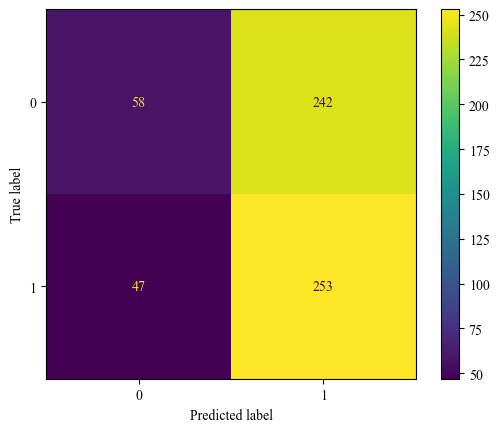

In [214]:
cm = confusion_matrix(y_true = label, y_pred = predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
#plt.savefig('./cm.png')

### Precision and Recall

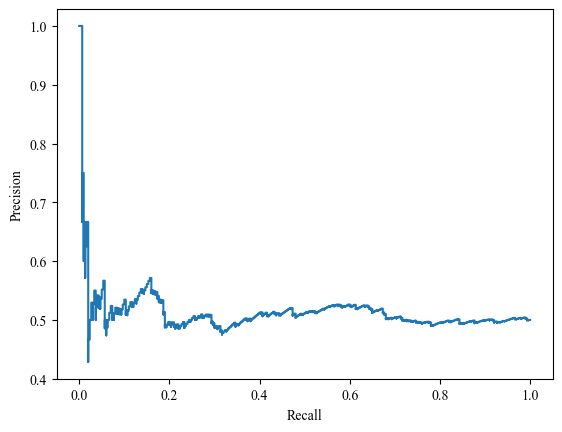

In [215]:
prec, recall, _ = precision_recall_curve(y_true = label, probas_pred = accuracy_score, pos_label=None)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
#plt.savefig('./pr.png')

### ROC Curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


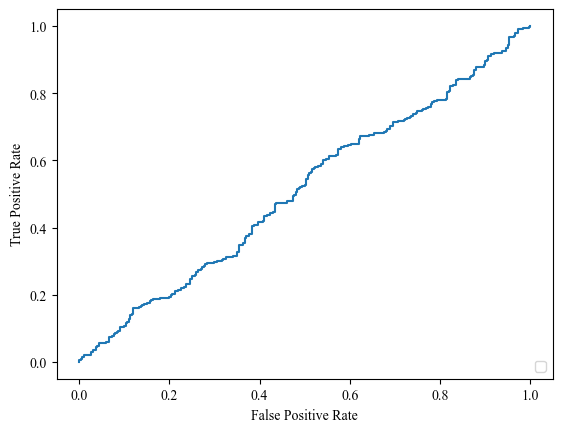

In [216]:
fpr, tpr, thresholds = roc_curve(y_true = label, y_score = accuracy_score, pos_label = None)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
#plt.savefig('./roc.png')